# **EXPERIMENT-2 : CRF_bilstm_word2vec_vs_charword**

In [1]:
import random
import numpy as np
import torch
import random
import torch.backends.cudnn as cudnn

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # slightly slower but reproducible

set_seed(24)

In [3]:
!pip install datasets
!pip install gensim
!pip install --upgrade --force-reinstall scipy
!pip install --upgrade --force-reinstall numpy gensim




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [4]:
!pip uninstall -y numpy gensim
!pip install numpy==1.24.4 gensim --force-reinstall --no-cache-dir


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 153.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 171.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 190.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled s

## Loading the PLOD-CW-25 Dataset

In [2]:
from datasets import load_dataset

ds = load_dataset("surrey-nlp/PLOD-CW-25")

/Users/amir/Desktop/data-science/second-semester/NLP/coursework/nlp_pg04/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Previewing example

In [3]:
from pprint import pprint
pprint(ds['train'][0] )


{'ner_tags': ['B-AC',
              'O',
              'B-LF',
              'I-LF',
              'I-LF',
              'O',
              'B-AC',
              'O',
              'B-LF',
              'I-LF',
              'I-LF',
              'O'],
 'pos_tags': ['NOUN',
              'PUNCT',
              'NOUN',
              'NOUN',
              'NOUN',
              'PUNCT',
              'PROPN',
              'PUNCT',
              'ADJ',
              'NOUN',
              'NOUN',
              'PUNCT'],
 'tokens': ['MRR',
            ',',
            'mortality',
            'rate',
            'ratio',
            ';',
            'TBI',
            ',',
            'traumatic',
            'brain',
            'injury',
            '.']}


## Split the Dataset into Train, Test, and Validation

We assign the different splits of the PLOD-CW-25 dataset to separate variables for better handling.


In [4]:
train_data = ds['train']
test_data = ds['test']
validate_data = ds['validation']

## general preprocessing

In [5]:
all_tokens = set([token for sent in train_data['tokens'] for token in sent])
ner_tags = set([tag for sent in train_data['ner_tags'] for tag in sent])

## Build Vocabulary from Training Tokens

We extract all tokens from all training sentences and flatten them into a single list for frequency counting. This allows us to build a vocabulary where each unique token is assigned a unique index. Special tokens like `<PAD>` and `<UNK>` are also added for padding and unknown words.


In [6]:
from collections import Counter

tokens_train = [ex['tokens'] for ex in ds['train']]

word_counter = Counter(token for sent in tokens_train for token in sent)

# Assign unique indices
word_vocab = {token: idx + 2 for idx, (token, _) in enumerate(word_counter.items())}
# equivilent to: token to id
word_vocab['<PAD>'] = 0
word_vocab['<UNK>'] = 1

## Functions to Convert Tokens and Tags to IDs (and vice versa)

These helper functions handle converting tokens and tags to their index values using lookup dictionaries. They also deal with unknown tokens or IDs by falling back to special defaults like `<UNK>` or `'O'`.


In [7]:
def token_to_id_fn(token, token_to_id):
    return token_to_id.get(token, token_to_id['<UNK>'])

def id_to_token_fn(idx, id_to_token):
    return id_to_token.get(idx, '<UNK>')

def tag_to_id_fn(tag, tag_to_id):
    return tag_to_id[tag]

def id_to_tag_fn(idx, id_to_tag):
    return id_to_tag.get(idx, 'O')

## Convert Tokens and Tags to Their Corresponding IDs

This function takes each example in the dataset and replaces the tokens and NER tags with their corresponding integer IDs using the vocab dictionaries.

In [8]:
def map_dataset(dataset, token_to_id, tag_to_id):
  mapped_dataset = []
  for row in dataset:
    tokens = row['tokens']
    ner_tags = row['ner_tags']
    mapped_tokens = [token_to_id.get(token, token_to_id['<UNK>']) for token in tokens]
    mapped_ner_tags = [tag_to_id[tag] for tag in ner_tags]
    mapped_dataset.append({
        'tokens': mapped_tokens,
        'ner_tags': mapped_ner_tags
    })
  return mapped_dataset

In [9]:
tag_to_id = {
    'O': 0,
    'B-LF': 1,
    'I-LF': 2,
    'B-AC': 3
}

## Convert Dataset Splits to ID Format

We apply the mapping function to the train, test, and validation splits to convert all tokens and tags to their corresponding integer IDs using the vocab dictionaries. This prepares the data for model input.


In [10]:
mapped_train_data = map_dataset(train_data, word_vocab, tag_to_id)
mapped_test_data = map_dataset(test_data, word_vocab, tag_to_id)
mapped_validate_data = map_dataset(validate_data, word_vocab, tag_to_id)

## Visualize Sentence Lengths in Training Data

We plot the distribution of token counts per sentence in the training data to understand length variability. The 99th percentile is marked to help decide a reasonable maximum sequence length for padding.


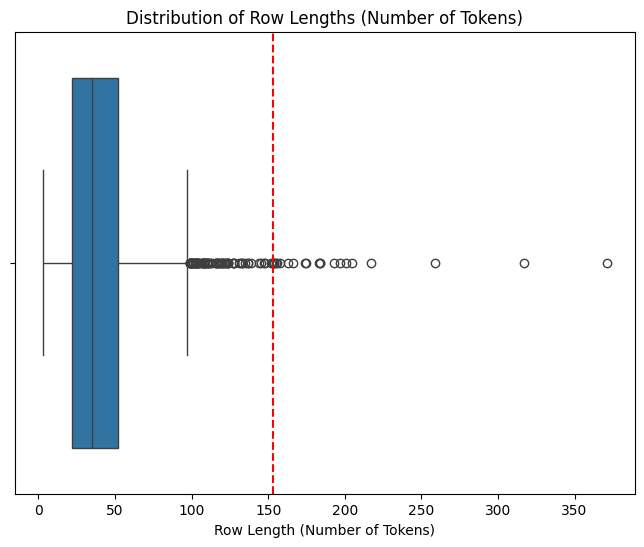

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

row_lengths = [len(sent['tokens']) for sent in mapped_train_data]


percentile = np.percentile(row_lengths, 99)
plt.figure(figsize=(8, 6))
sns.boxplot(x=row_lengths)
plt.axvline(x=np.percentile(row_lengths, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of Row Lengths (Number of Tokens)")
plt.xlabel("Row Length (Number of Tokens)")
plt.show()

## Plot Summary

*   The boxplot shows that most sentences are relatively short, with the majority falling well below 100 tokens.
*   A few outliers go beyond 150 tokens.
*   The red dashed line marks the 99th percentile, which is around 150 tokens.
*   This means we can safely set the maximum sequence length to 150, covering nearly all sentences while limiting the impact of unusually long ones.


## Pad and Truncate Dataset to a Fixed Length

We set a maximum sequence length of 150 based on the earlier analysis. This function goes through each example and either truncates or pads the tokens and tags to match this length. It also creates a mask to distinguish real tokens from padding.


In [12]:
MAX_LENGTH = 150

def pad_dataset(dataset, max_length):
    padded_dataset = []
    for row in dataset:
        tokens = row['tokens']
        ner_tags = row['ner_tags']
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
            ner_tags = ner_tags[:max_length]

        else:
            tokens += [0] * (max_length - len(tokens))
            ner_tags += [0] * (max_length - len(ner_tags))

        mask = [1 if token != 0 else 0 for token in tokens]

        padded_dataset.append({
            'tokens': tokens,
            'ner_tags': ner_tags,
            'mask': mask
        })

    return padded_dataset

## Apply Padding and Truncation to All Dataset Splits

We now apply the padding function to the train, test, and validation sets. Each example is padded or truncated to the same fixed length and a corresponding mask is added to indicate real tokens vs. padding.


In [13]:
padded_train_data = pad_dataset(mapped_train_data, MAX_LENGTH)
padded_test_data = pad_dataset(mapped_test_data, MAX_LENGTH)
padded_validate_data = pad_dataset(mapped_validate_data, MAX_LENGTH)

## Set Vocabulary Size and Embedding Dimension

In [14]:
VOCAB_SIZE = len(word_vocab)
DIM = 100

In [15]:
import os
import urllib.request

file_name = 'bio_embedding_extrinsic'
download_url = 'https://figshare.com/ndownloader/files/12551780'

if os.path.exists(file_name):
    print(f"File {file_name} already exists. Skipping download.")
else:
    print(f"Downloading {file_name} from {download_url}...")
    urllib.request.urlretrieve(download_url, file_name)
    print(f"Downloaded {file_name}.")


File bio_embedding_extrinsic already exists. Skipping download.


## Embedding

### Embeddings Used

We used **pretrained biomedical word embeddings** from:

> **Zhang et al. (2019)** — *Improving Biomedical Word Embeddings with Subword Information and MeSH Ontology*  
> Available via [Figshare](https://figshare.com/articles/dataset/BioWordVec_Improving_Biomedical_Word_Embeddings_with_Subword_Information_and_MeSH_Ontology/6885640)

These embeddings, commonly known as **BioWordVec**, are trained on **PubMed abstracts** and incorporate:
- **Subword information** via FastText-style modeling
- **MeSH ontology knowledge** to enhance domain-specific semantics

Their design makes them highly suitable for **biomedical NLP tasks** such as **Named Entity Recognition (NER)**, where vocabulary can be complex, domain-specific, and morphologically rich.


In [16]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_path = "bio_embedding_extrinsic"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

### Verify Loaded Word2Vec Model

We confirm that the pretrained Word2Vec model has loaded successfully by printing the embedding dimensionality and vocabulary size.


In [17]:
# checking vector size
print(f"Embedding vector size: {w2v_model.vector_size}")

# checking vocabulary size
print(f"Vocabulary size: {len(w2v_model.key_to_index)} words")

Embedding vector size: 200
Vocabulary size: 2324849 words


### Create Embedding Matrix with Pretrained Word2Vec Vectors

In [18]:
import numpy as np

# setting up embedding matrix
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word_vocab), embedding_dim))


# fill the matrix
for word, idx in word_vocab.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

### Verify Embedding Matrix

We verify that the embedding matrix has the correct shape, check how many words from our dataset are covered by the pretrained Word2Vec model, and inspect the embedding for a sample word.


In [19]:
# 1. Check dimensions
print(f"Embedding matrix shape: {embedding_matrix.shape}")
assert embedding_matrix.shape[0] == len(word_vocab), "Mismatch in vocab size!"
assert embedding_matrix.shape[1] == w2v_model.vector_size, "Mismatch in embedding dim!"

# 2. Check OOV (out of vocab) words
covered = sum(1 for word in word_vocab if word in w2v_model)
total = len(word_vocab)
print(f"Coverage: {covered}/{total} words ({covered/total*100:.2f}%)")

# 3. Sample vector check
sample_word = 'glucose'
if sample_word in word_vocab:
    idx = word_vocab[sample_word]
    print(f"Sample vector for '{sample_word}': {embedding_matrix[idx][:10]}")
else:
    print(f"'{sample_word}' not found in word_vocab")

Embedding matrix shape: (14742, 200)
Coverage: 7463/14742 words (50.62%)
Sample vector for 'glucose': [ 0.30148456  0.06259853  0.06257256  0.02667626 -0.30542654  0.30082998
 -0.14734118 -0.20231321  0.28477651 -0.29688197]


### List Out OOV (Out-of-Vocabulary) Words

In [20]:
# List out OOV words
oov_words = [word for word in word_vocab if word not in w2v_model]

# Show a few (first 20)
print(f"Total OOV words: {len(oov_words)} / {len(word_vocab)}")
print("Sample OOV words:")
for i, word in enumerate(oov_words[:20]):
    print(f"{i+1:2d}. {word}")

Total OOV words: 7279 / 14742
Sample OOV words:
 1. MRR
 2. ,
 3. ;
 4. TBI
 5. .
 6. HPC
 7. mOFC
 8. OFC
 9. PPI
10. In
11. 18β
12. GA
13. (
14. AQP-3
15. )
16. Abbreviations
17. :
18. HC
19. C
20. KD


### Analyze Frequency of OOV Words

In [21]:
# Assuming you have a `word_counter` (e.g., from collections.Counter)
from collections import Counter

# Build a frequency dict of just the OOV words
oov_freq = {word: word_counter[word] for word in oov_words if word in word_counter}

# Sort by frequency
top_oov = sorted(oov_freq.items(), key=lambda x: -x[1])[:20]

# Print top frequent OOVs
print(" Top Frequent OOV Words:")
for word, freq in top_oov:
    print(f"{word:15s} → {freq}")


 Top Frequent OOV Words:
,               → 5206
(               → 2965
)               → 2930
.               → 2321
;               → 1989
]               → 640
[               → 620
:               → 405
The             → 315
/               → 286
=               → 260
%               → 225
–               → 151
C               → 145
Fig             → 117
A               → 115
We              → 107
CI              → 103
In              → 100
RNA             → 81


### Check Word Presence in Pretrained Embedding Model

In [22]:
# Let's inspect a few known biomedical words in the pretrained embedding model
# We will look for both cased and lowercased versions

words_to_check = ["Glucose", "glucose", "Insulin", "insulin", "COVID", "covid"]
availability = {word: word in w2v_model for word in words_to_check}
availability

{'Glucose': False,
 'glucose': True,
 'Insulin': False,
 'insulin': True,
 'COVID': False,
 'covid': False}

### Inspect Cosine Similarity Distribution of Random Word Pairs

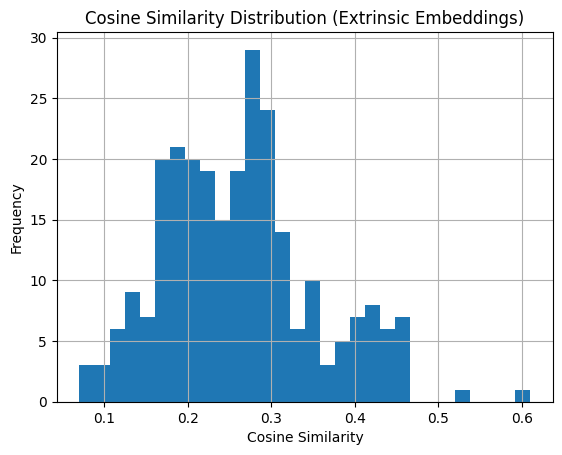

In [23]:
import random
import matplotlib.pyplot as plt

# Sample random word pairs
words = random.sample(list(word_vocab.keys()), 1000)
similarities = []
for i in range(len(words)-1):
    w1, w2 = words[i], words[i+1]
    if w1 in w2v_model and w2 in w2v_model:
        sim = w2v_model.similarity(w1, w2)
        similarities.append(sim)

# Plot
plt.hist(similarities, bins=30)
plt.title("Cosine Similarity Distribution (Extrinsic Embeddings)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Explore Semantically Similar Words to "Glucose"

We use the pretrained Word2Vec model to retrieve the top 5 most similar words to "glucose" based on cosine similarity. This helps verify the semantic quality of the embeddings in a biomedical context.


In [24]:
w2v_model.most_similar('glucose', topn=5)

[('qglucose', 0.8199415802955627),
 ('rglucose', 0.8195745944976807),
 ('glucose-time', 0.8183287978172302),
 ('iv-glucose', 0.8175548315048218),
 ('cglucose', 0.8104894757270813)]

### Visualize Similar Words to "Glucose" Using PCA

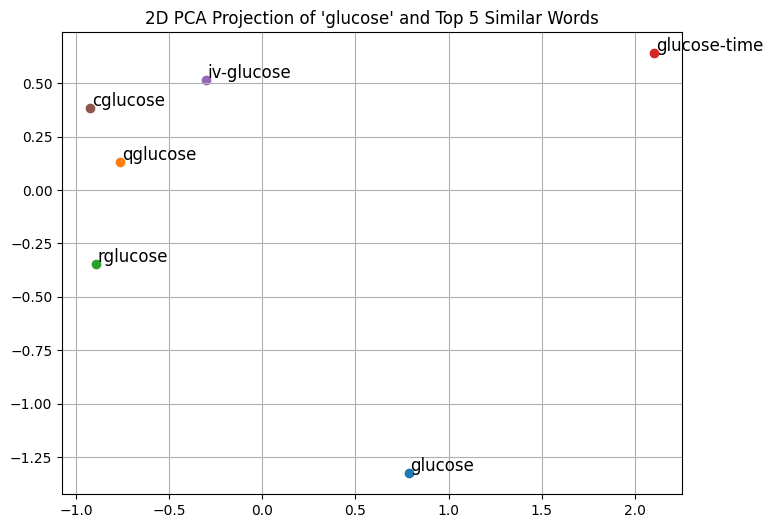

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get top 5 most similar words
word = 'glucose'
topn = 5
similar_words = w2v_model.most_similar(word, topn=topn)

# Collect word vectors
words = [word] + [w for w, _ in similar_words]  # include 'glucose' itself
vectors = [w2v_model[w] for w in words]

# Reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(words):
    x, y = reduced_vectors[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=12)

plt.title(f"2D PCA Projection of '{word}' and Top {topn} Similar Words")
plt.grid(True)
plt.show()


### Define a PyTorch Module for Pretrained Word Embeddings

In [26]:
import torch.nn as nn
class PretrainedWordEmbedding(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.output_dim = embedding_matrix.shape[1]

    def forward(self, word_ids, char_ids=None):
        return self.word_embedding(word_ids)


## Combined words and char embeddings with ngram

### Define a PyTorch Module for Pretrained Word Embeddings

In [27]:
import torch
import torch.nn as nn

word_embedding = nn.Embedding(VOCAB_SIZE, DIM)

### Build Character Vocabulary for Char-Level Embeddings

In [28]:
chars = set([c for token in all_tokens for c in token])
char_to_id = {char: idx + 2 for idx, char in enumerate(chars)}
char_to_id['<PAD>'] = 0
char_to_id['<UNK>'] = 1

### Analyze Word Lengths for Character Embeddings

We visualize the distribution of word lengths (in characters) to help choose a reasonable maximum length for character-level embeddings. The 99th percentile is marked to guide truncation and padding decisions for input words.


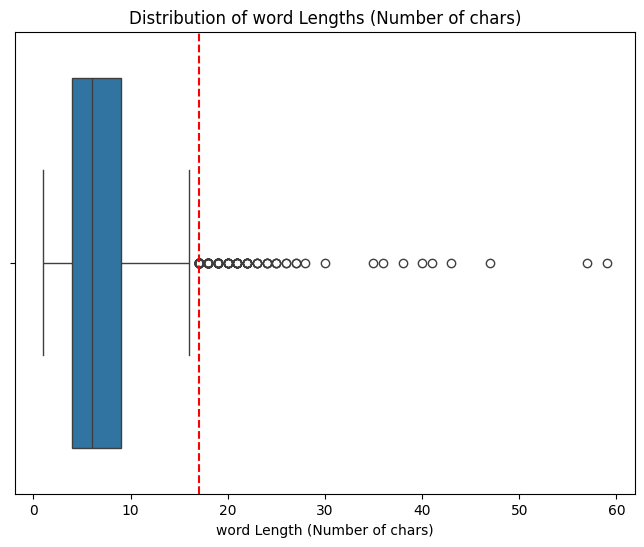

In [29]:
word_lengths = [len(w) for w in all_tokens]

plt.figure(figsize=(8, 6))
sns.boxplot(x=word_lengths)
plt.axvline(x=np.percentile(word_lengths, 99), color='red', linestyle='--', label='99th Percentile')
plt.title("Distribution of word Lengths (Number of chars)")
plt.xlabel("word Length (Number of chars)")
plt.show()

In [30]:
MAX_LENGTH_WORD = 15

In [31]:
def word_to_char_ids(word, char_to_id):
    char_ids = [char_to_id.get(c, char_to_id['<UNK>']) for c in word]
    char_ids = char_ids[:MAX_LENGTH_WORD]
    char_ids += [char_to_id['<PAD>']] * (MAX_LENGTH_WORD - len(char_ids))
    return char_ids

In [32]:
def convert_tokens_to_char_ids(dataset, id_to_token_fn, char_to_id, token_to_id): # Added token_to_id as argument
    """Convert token IDs in a dataset to lists of character IDs per token."""
    updated_dataset = []

    # Create the id_to_token dictionary using token_to_id
    id_to_token = {v: k for k, v in token_to_id.items()} # Create the id_to_token dictionary

    for row in dataset:
        token_ids = row['tokens']
        char_id_seqs = []

        for token_id in token_ids:
            token = id_to_token.get(token_id, '<UNK>')
            char_ids = word_to_char_ids(token, char_to_id)
            char_id_seqs.append(char_ids)

        updated_dataset.append({
            'tokens': char_id_seqs,
            'ner_tags': row['ner_tags']
        })

    return updated_dataset

train_char_dataset = convert_tokens_to_char_ids(padded_train_data, id_to_token_fn, char_to_id, word_vocab)
test_char_dataset = convert_tokens_to_char_ids(padded_test_data, id_to_token_fn, char_to_id, word_vocab)
validate_char_dataset = convert_tokens_to_char_ids(padded_validate_data, id_to_token_fn, char_to_id, word_vocab)

In [33]:
class WordAndCharEmbedding(nn.Module):
    def __init__(self, word_vocab_size, word_embedding_dim, char_vocab_size, char_embedding_dim, hidden_dim):
        super().__init__()

        # word-level embedding
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim, padding_idx=0)

        # char-level embedding
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim, padding_idx=0)
        self.char_lstm = nn.LSTM(char_embedding_dim, hidden_dim // 2, bidirectional=True, batch_first=True, num_layers=1)

        self.dropout = nn.Dropout(0.5)
        self.output_dim = word_embedding_dim + hidden_dim

    def forward(self, word_ids, char_ids):
        batch_size, seq_len, max_word_len = char_ids.size()

        word_emb = self.word_embedding(word_ids)                          # [B, L, D_word]
        char_ids = char_ids.view(-1, max_word_len)                        # [B*L, max_len]
        char_emb = self.char_embedding(char_ids)                          # [B*L, max_len, D_char]

        _, (hidden, _) = self.char_lstm(char_emb)                         # hidden: [2, B*L, H/2]
        char_repr = torch.cat([hidden[0], hidden[1]], dim=-1)             # [B*L, H]
        char_repr = char_repr.view(batch_size, seq_len, -1)               # [B, L, H]

        combined = torch.cat([word_emb, char_repr], dim=-1)               # [B, L, D_word + H]
        return self.dropout(combined)


In [34]:
word_char_embedding = WordAndCharEmbedding(
    word_vocab_size=VOCAB_SIZE,
    word_embedding_dim=DIM,  # Word embedding dimension
    char_vocab_size=len(char_to_id),
    char_embedding_dim=50,  # Character embedding dimension
    hidden_dim=100           # Hidden dimension for char-level LSTM
)

embedding_dim = DIM + 100


In [35]:
word_ids = torch.randint(0, len(word_vocab), (32, 50))
char_ids = torch.randint(0, len(char_to_id), (32, 50, 12))

combined = word_char_embedding(word_ids, char_ids)
print(combined.shape)

torch.Size([32, 50, 200])


## installing PyTorch-CRF

In [36]:
 !pip install git+https://github.com/kmkurn/pytorch-crf.git

  Cloning https://github.com/kmkurn/pytorch-crf.git to /tmp/pip-req-build-b0ijf0bz
  Running command git clone --filter=blob:none --quiet https://github.com/kmkurn/pytorch-crf.git /tmp/pip-req-build-b0ijf0bz
  Resolved https://github.com/kmkurn/pytorch-crf.git to commit 623e3402d00a2728e99d6e8486010d67c754267b
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-crf: filename=pytorch_crf-0.7.2-py3-none-any.whl size=6410 sha256=2a17320511458e8698dcb4c3867a14bff62adf18e251ece0831ebeb9bf0a6b08
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvm7fwt6/wheels/fd/83/cc/f11543939f8911b8dcff86e2bd54423e21f779d0938958cc7f
Successfully built pytorch-crf


## define model (crf + biLSTM)

In [36]:
import torch
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_labels):
        super().__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(self.embedding.output_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, word_ids, char_ids=None, labels=None, mask=None):
        if char_ids is not None:
            embeddings = self.embedding(word_ids, char_ids)
        else:
            embeddings = self.embedding(word_ids)
        lstm_out, _ = self.lstm(embeddings)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            return -self.crf(emissions, labels, mask=mask, reduction='mean')
        else:
            return self.crf.decode(emissions, mask=mask)


### NERDataset Class

This class defines a custom PyTorch `Dataset` for Named Entity Recognition (NER) tasks.

- **Inputs:**
  - `word_data`: A list of dictionaries containing word-level token IDs, NER tags, and attention masks.
  - `char_data` *(optional)*: A list of dictionaries containing character-level token IDs for each word.

- **Output:**
  - If `char_data` is provided: returns a tuple `(tokens, char_ids, ner_tags, mask)`
  - Otherwise: returns `(tokens, ner_tags, mask)`

The dataset is designed to be compatible with `DataLoader` for efficient batching during training or evaluation.


In [37]:
from torch.utils.data import Dataset

class NERDataset(Dataset):
    def __init__(self, word_data, char_data=None):
        self.word_data = word_data
        self.char_data = char_data

    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        word_item = self.word_data[idx]
        tokens = torch.tensor(word_item['tokens'], dtype=torch.long)
        ner_tags = torch.tensor(word_item['ner_tags'], dtype=torch.long)
        mask = torch.tensor(word_item['mask'], dtype=torch.bool)

        if self.char_data is not None:
            char_item = self.char_data[idx]
            char_ids = torch.tensor(char_item['tokens'], dtype=torch.long)
            return tokens, char_ids, ner_tags, mask
        else:
            return tokens, ner_tags, mask

## Dataset Initialization

We create three instances of the custom `NERDataset` class for training, validation, and test splits.

Each dataset takes:
- `padded_*_data`: Word-level input data with token IDs, NER tags, and attention masks.
- `*_char_dataset`: (Optional) Character-level input data for each word, useful for models that incorporate sub-word features.




In [38]:
train_dataset = NERDataset(padded_train_data, train_char_dataset)
test_dataset = NERDataset(padded_test_data, test_char_dataset)
validate_dataset = NERDataset(padded_validate_data, validate_char_dataset)

### Custom Collate Function

This `collate_fn` is used with PyTorch `DataLoader` to batch variable-length samples from the `NERDataset`.

It supports both:
- Word-only input: `(tokens, ner_tags, mask)`
- Word + character input: `(tokens, char_ids, ner_tags, mask)`

The function stacks the tensors along the batch dimension for each field, allowing the model to process input in mini-batches.


In [39]:
def collate_fn(batch):
    if len(batch[0]) == 4:
        tokens, char_ids, ner_tags, masks = zip(*batch)
        return (
            torch.stack(tokens),
            torch.stack(char_ids),
            torch.stack(ner_tags),
            torch.stack(masks)
        )
    else:
        tokens, ner_tags, masks = zip(*batch)
        return (
            torch.stack(tokens),
            torch.stack(ner_tags),
            torch.stack(masks)
        )


## training and evaluation

In [40]:
# Hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32

## Evaluation function

In [41]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_model(model, dataloader, id_to_tag=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                predictions = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                predictions = model(tokens, mask=mask)

            for pred_seq, true_seq, m in zip(predictions, tags, mask):
                seq_len = m.sum().item()
                pred = pred_seq[:seq_len]
                true = true_seq[:seq_len].tolist()

                all_preds.extend(pred)
                all_labels.extend(true)

    model.train()

    f1 =  f1_score(all_labels, all_preds, average="macro")

    return f1


### Training Function

The `train_model` function handles the full training loop for the NER model.

## save model to huggingface hub

it this section to make the marking easier and less time consuming. we have intoduced a new function `save_model_to_huggingface_hub` that will save the model to the huggingface hub.
if you dont want to wait for the model to be trained you can skip this section and run the next cell to load the model from the huggingface hub

In [42]:
from huggingface_hub import create_repo, upload_file
import torch

def save_model_to_hub(model, model_name, repo_name='nlp-pg04', username='amirghasemiveisi'):
    """
    Save a PyTorch model to the Hugging Face Hub.
    
    Args:
        model: Trained PyTorch model (nn.Module)
        model_name: The name of the model (used as file name and commit label)
        repo_name: The Hugging Face repo name (within your account)
        username: Your Hugging Face username
    """
    
    model_file = f"{model_name}.pt"
    torch.save(model.state_dict(), model_file)

    
    repo_id = f"{username}/{repo_name}"

    
    create_repo(repo_id, exist_ok=True)

    
    upload_file(
        path_or_fileobj=model_file,
        path_in_repo="pytorch_model.bin",
        repo_id=repo_id,
        repo_type="model",
        commit_message=f"Upload model {model_name}",
    )

    print(f"Uploaded to https://huggingface.co/{repo_id}/blob/main/pytorch_model.bin")

In [43]:
import torch

def train_model(
    model,
    train_loader,
    optimizer,
    num_epochs=5,
    val_loader=None,
    id_to_tag=None,
    save_path="best_model.pt"
):
    best_f1 = -1.0
    train_loss = []
    f1_scores = []
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0

        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                loss = model(tokens, char_ids=char_ids, labels=tags, mask=mask)
            else:
                tokens, tags, mask = batch
                loss = model(tokens, labels=tags, mask=mask)

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Training Loss: {total_loss:.4f}")

        if val_loader is not None and id_to_tag is not None:
            f1_score = evaluate_model(model, val_loader, id_to_tag)
            f1_scores.append(f1_score)
            print(f"f1 score  - {f1_score}")

            # Save best model by F1
            if f1_score > best_f1:
                best_f1 = f1_score
                torch.save(model.state_dict(), save_path)
                print(f"Best model updated and saved to: {save_path}")
    return train_loss, f1_scores


In [44]:
## Dataloader initialisation

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Training BiLSTM-CRF with Pretrained Word Embeddings

the variable `LOAD_FROM_HUGGINGFACE` is set to `True` to load the model from the huggingface hub. if you want to train the model from scratch set it to `False` and run the cell below.
`LOAD_FROM_HUGGINGFACE = True`

In [45]:
LOAD_FROM_HUGGINGFACE = True
SAVE_TO_HUGGINGFACE = True

In [46]:
from torch.optim import Adam
from huggingface_hub import hf_hub_download
import torch
import os

MODEL_NAME = "w2v_model"
REPO_ID = "amirghasemiveisi/nlp-pg04"
LOCAL_MODEL_PATH = "w2v_model.pt"


w2v_embedding = PretrainedWordEmbedding(embedding_matrix)

model_w2v = BiLSTM_CRF(
    embedding_layer=w2v_embedding,
    hidden_dim=256,
    num_labels=len(tag_to_id)
)


with torch.no_grad():
    model_w2v.crf.start_transitions[tag_to_id['B-AC']] -= 2.0
    model_w2v.crf.transitions[tag_to_id['O'], tag_to_id['I-LF']] -= 2.0
    model_w2v.crf.transitions[tag_to_id['I-LF'], tag_to_id['B-AC']] -= 2.0


optimizer_w2v = Adam(model_w2v.parameters(), lr=0.001)

# Load from HF if enabled
if LOAD_FROM_HUGGINGFACE:
    print("Loading model from Hugging Face Hub...")
    model_path = hf_hub_download(
        repo_id=REPO_ID,
        filename="pytorch_model.bin",
        repo_type="model"
    )
    model_w2v.load_state_dict(torch.load(model_path))
    model_w2v.eval()
    print("Model loaded from Hugging Face.")

else:
    print("Training model locally...")
    w2v_loss, w2v_f1 = train_model(
        model_w2v,
        train_loader,
        optimizer_w2v,
        num_epochs=NUM_EPOCHS,
        val_loader=validate_loader,
        id_to_tag=tag_to_id,
        save_path=LOCAL_MODEL_PATH
    )
    print("Training complete.")
    
    model_w2v.load_state_dict(torch.load(LOCAL_MODEL_PATH))

    # Save to Hugging Face if enabled
    if SAVE_TO_HUGGINGFACE:
        print("Uploading model to Hugging Face Hub...")
        save_model_to_hub(
            model=model_w2v,
            model_name=MODEL_NAME,
            repo_name="nlp-pg04",
            username="amirghasemiveisi"
        )

Loading model from Hugging Face Hub...


RuntimeError: Error(s) in loading state_dict for BiLSTM_CRF:
	Unexpected key(s) in state_dict: "embedding.char_embedding.weight", "embedding.char_lstm.weight_ih_l0", "embedding.char_lstm.weight_hh_l0", "embedding.char_lstm.bias_ih_l0", "embedding.char_lstm.bias_hh_l0", "embedding.char_lstm.weight_ih_l0_reverse", "embedding.char_lstm.weight_hh_l0_reverse", "embedding.char_lstm.bias_ih_l0_reverse", "embedding.char_lstm.bias_hh_l0_reverse". 
	size mismatch for embedding.word_embedding.weight: copying a param with shape torch.Size([14742, 100]) from checkpoint, the shape in current model is torch.Size([14742, 200]).

### Training BiLSTM-CRF with Combined Word and Character Embeddings

In [61]:
from huggingface_hub import hf_hub_download
from torch.optim import Adam
import torch

MODEL_NAME_COMBINED = "combined_model"
REPO_ID_COMBINED = "amirghasemiveisi/nlp-pg04"
LOCAL_MODEL_PATH_COMBINED = "combined_model.pt"

combined_embedding = WordAndCharEmbedding(
    word_vocab_size=VOCAB_SIZE,
    word_embedding_dim=DIM,
    char_vocab_size=len(char_to_id),
    char_embedding_dim=50,
    hidden_dim=100
)

model_combined = BiLSTM_CRF(
    embedding_layer=combined_embedding,
    hidden_dim=256,
    num_labels=len(tag_to_id)
)

with torch.no_grad():
    model_combined.crf.start_transitions[tag_to_id['B-AC']] -= 2.0
    model_combined.crf.transitions[tag_to_id['O'], tag_to_id['I-LF']] -= 2.0
    model_combined.crf.transitions[tag_to_id['I-LF'], tag_to_id['B-AC']] -= 2.0

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

optimizer_combined = Adam(model_combined.parameters(), lr=0.001)

if LOAD_FROM_HUGGINGFACE:
    model_path = hf_hub_download(
        repo_id=REPO_ID_COMBINED,
        filename="pytorch_model.bin",
        repo_type="model"
    )
    model_combined.load_state_dict(torch.load(model_path))
    model_combined.eval()
else:
    combined_loss, combined_f1 = train_model(
        model_combined,
        train_loader,
        optimizer_combined,
        num_epochs=NUM_EPOCHS,
        val_loader=validate_loader,
        id_to_tag=tag_to_id,
        save_path=LOCAL_MODEL_PATH_COMBINED
    )

    model_combined.load_state_dict(torch.load(LOCAL_MODEL_PATH_COMBINED))

    if SAVE_TO_HUGGINGFACE:
        save_model_to_hub(
            model=model_combined,
            model_name=MODEL_NAME_COMBINED,
            repo_name="nlp-pg04",
            username="amirghasemiveisi"
        )

### Tag ID to Label Mapping

In [62]:
id2tag = {v: k for k, v in tag_to_id.items()}

In [50]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=68443fa90554db683bc4c2112b66324ea2767c35da67a7dfed9a1825e8f5d536
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


### Evaluation Using `seqeval`

In [63]:
from seqeval.metrics import classification_report

def evaluate_seqeval(model, dataloader, tag_to_id):
    id2tag = {v: k for k, v in tag_to_id.items()}
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                preds = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                preds = model(tokens, mask=mask)

            for pred_seq, true_seq, m in zip(preds, tags, mask):
                seq_len = m.sum().item()
                pred_tags = [id2tag[p] for p in pred_seq[:seq_len]]
                true_tags = [id2tag[t.item()] for t in true_seq[:seq_len]]

                all_preds.append(pred_tags)
                all_labels.append(true_tags)

    model.train()
    print(classification_report(all_labels, all_preds))


### Final Evaluation on Test Set

In [64]:

print("Evaluation for Word2Vec embedding:")
evaluate_seqeval(model_w2v, test_loader, tag_to_id)


print("Evaluation for Word+Char embedding:")
evaluate_seqeval(model_combined, test_loader, tag_to_id)


Evaluation for Word2Vec embedding:
              precision    recall  f1-score   support

          AC       0.82      0.69      0.75       793
          LF       0.71      0.65      0.67       481

   micro avg       0.78      0.68      0.72      1274
   macro avg       0.76      0.67      0.71      1274
weighted avg       0.78      0.68      0.72      1274

Evaluation for Word+Char embedding:
              precision    recall  f1-score   support

          AC       0.55      0.90      0.68       793
          LF       0.63      0.69      0.66       481

   micro avg       0.57      0.82      0.67      1274
   macro avg       0.59      0.79      0.67      1274
weighted avg       0.58      0.82      0.67      1274



### Training Loss Comparison

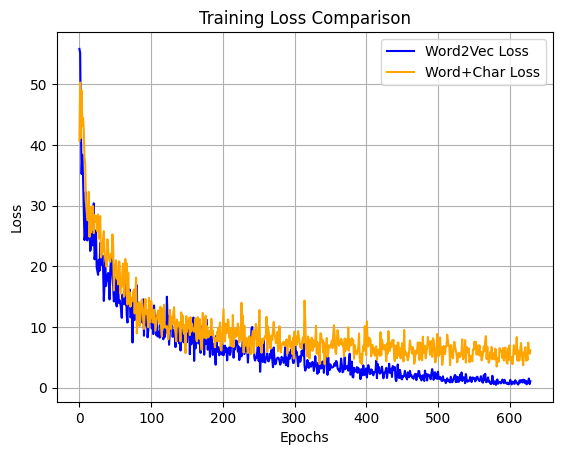

In [65]:
# digram to compare two models training loss
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.plot(w2v_loss, label='Word2Vec Loss', color='blue')
plt.plot(combined_loss, label='Word+Char Loss', color='orange')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### F1 Score Comparison

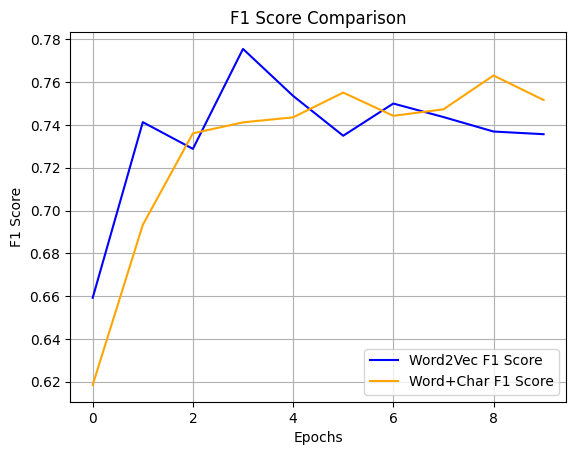

In [68]:
# digram to compare two models f1 score
plt.plot(w2v_f1, label='Word2Vec F1 Score', color='blue')
plt.plot(combined_f1, label='Word+Char F1 Score', color='orange')
plt.title('F1 Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

## Error analysis

### Confusion Matrix for NER Tags

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_ner_confusion_data(predictions, tag_list):
    all_preds, all_trues = [], []
    for _, preds, trues in predictions:
        for p, t in zip(preds, trues):
            all_preds.append(p)
            all_trues.append(t)

    cm = confusion_matrix(all_trues, all_preds, labels=tag_list, normalize='true')
    return cm


### Confusion Matrix Comparison for NER Models


In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
def compare_ner_confusion_matrices(predictions_1, predictions_2, tag_list, labels=("Model 1", "Model 2")):
    cm1 = get_ner_confusion_data(predictions_1, tag_list)
    cm2 = get_ner_confusion_data(predictions_2, tag_list)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for ax, cm, label in zip(axes, [cm1, cm2], labels):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tag_list)
        disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
        ax.set_title(f"Confusion Matrix: {label}")
        ax.grid(False)

    plt.tight_layout()
    plt.show()


### Collecting NER Predictions

In [59]:
def collect_predictions(model, dataloader, id_to_tag, id_to_word=None, device='cpu'):
    model.eval()
    all_examples = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                tokens, char_ids, tags, mask = batch
                tokens, char_ids, tags, mask = map(lambda x: x.to(device), (tokens, char_ids, tags, mask))
                preds = model(tokens, char_ids=char_ids, mask=mask)
            else:
                tokens, tags, mask = batch
                tokens, tags, mask = map(lambda x: x.to(device), (tokens, tags, mask))
                preds = model(tokens, mask=mask)

            for tok_ids, pred_seq, true_seq, m in zip(tokens, preds, tags, mask):
                seq_len = int(m.sum().item())
                pred_tags = [id_to_tag[p] for p in pred_seq[:seq_len]]
                true_tags = [id_to_tag[t.item()] for t in true_seq[:seq_len]]

                if id_to_word is not None:
                    words = [id_to_word[t.item()] for t in tok_ids[:seq_len]]
                else:
                    words = None

                all_examples.append((words, pred_tags, true_tags))

    model.train()
    return all_examples


### Final Confusion Matrix Comparison

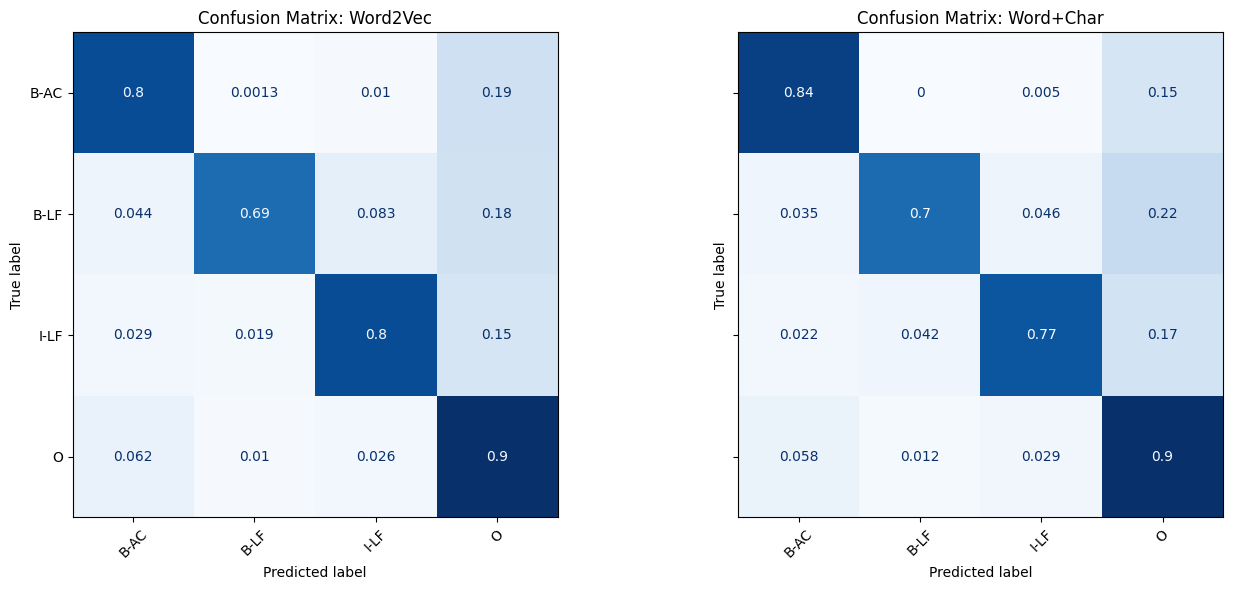

In [62]:
predictions_w2v = collect_predictions(model_w2v, test_loader, id2tag)
predictions_combined = collect_predictions(model_combined, test_loader, id2tag)

tag_list = sorted(set(tag for preds in [predictions_w2v, predictions_combined]
                      for _, p, t in preds for tag in p + t))

compare_ner_confusion_matrices(predictions_w2v, predictions_combined, tag_list, labels=("Word2Vec", "Word+Char"))


### Confusion Matrix Analysis: Word2Vec vs. Word+Char Models

We compared the performance of two NER models using normalized confusion matrices:

- **Model 1**: Word2Vec-only
- **Model 2**: Word + Character-level BiLSTM

#### Key Observations:

- **`B-AC` (Begin-AC)**:
  - Word2Vec: 80% correct, 19% misclassified as `O`.
  - Word+Char: Improved to **84%** correct, reduced confusion with `O`.

- **`B-LF` (Begin-LF)**:
  - Word2Vec: 69% correct, 18% → `O`, 8% → `I-LF`.
  - Word+Char: Slight improvement to 70%, with a small increase in `O` misclassification (22%).

- **`I-LF` (Inside-LF)**:
  - Word2Vec: 80% correct, 15% → `O`.
  - Word+Char: Slight dip to 77%, with a few more cases misclassified as `B-LF`.

- **`O` (Outside tag)**:
  - Both models show similar accuracy (~90%), with some confusion from boundary labels like `B-AC`.

#### ✅ Takeaway:
Character-level features improve classification of boundary entity tags (`B-AC`, `B-LF`), especially in distinguishing them from non-entity tokens (`O`). However, the added complexity introduces some trade-offs in adjacent class confusion, which is common in sequence labeling tasks.

These findings suggest the **Word+Char model generalizes slightly better**, particularly for detecting the beginning of entities with morphological cues.


In [63]:
from collections import Counter

def get_top_confusions(predictions, top_k=10, exclude_correct=True):
    confusion_counts = Counter()

    for _, pred_tags, true_tags in predictions:
        for pred, true in zip(pred_tags, true_tags):
            if exclude_correct and pred == true:
                continue
            confusion_counts[(true, pred)] += 1

    most_common = confusion_counts.most_common(top_k)
    print(f"\nTop {top_k} Tag Confusions:\n")
    for (true, pred), count in most_common:
        print(f"True: {true:<6} → Pred: {pred:<6} | Count: {count}")


### Tag Confusion Analysis: Word2Vec vs Word+Char Models

In [64]:
print("Word2Vec Confusions:")
get_top_confusions(predictions_w2v)

print("Word+Char Confusions:")
get_top_confusions(predictions_combined)


Word2Vec Confusions:

Top 10 Tag Confusions:

True: O      → Pred: B-AC   | Count: 474
True: O      → Pred: I-LF   | Count: 201
True: I-LF   → Pred: O      | Count: 186
True: B-AC   → Pred: O      | Count: 147
True: B-LF   → Pred: O      | Count: 86
True: O      → Pred: B-LF   | Count: 80
True: B-LF   → Pred: I-LF   | Count: 40
True: I-LF   → Pred: B-AC   | Count: 36
True: I-LF   → Pred: B-LF   | Count: 23
True: B-LF   → Pred: B-AC   | Count: 21
Word+Char Confusions:

Top 10 Tag Confusions:

True: O      → Pred: B-AC   | Count: 443
True: O      → Pred: I-LF   | Count: 220
True: I-LF   → Pred: O      | Count: 205
True: B-AC   → Pred: O      | Count: 119
True: B-LF   → Pred: O      | Count: 107
True: O      → Pred: B-LF   | Count: 95
True: I-LF   → Pred: B-LF   | Count: 51
True: I-LF   → Pred: B-AC   | Count: 27
True: B-LF   → Pred: I-LF   | Count: 22
True: B-LF   → Pred: B-AC   | Count: 17


In [65]:
id_to_token = {v: k for k, v in word_vocab.items()}

### Most Frequently Missed Tokens (False Negatives)

In [66]:
from collections import Counter

def get_most_missed_tokens(predictions, target_tags={"B-AC", "I-AC", "B-LF", "I-LF"}, top_k=20):
    missed = Counter()

    for tokens, pred_tags, true_tags in predictions:
        for word, pred, true in zip(tokens, pred_tags, true_tags):
            if true in target_tags and pred != true:
                missed[word] += 1

    print(f"\nTop {top_k} most frequently misclassified tokens (FN):\n")
    for token, count in missed.most_common(top_k):
        print(f"{token:<20} | Missed: {count}")


predictions_w2v = collect_predictions(model_w2v, test_loader, id2tag, id_to_token)
get_most_missed_tokens(predictions_w2v)

predictions_combined = collect_predictions(model_combined, test_loader, id2tag, id_to_token)
get_most_missed_tokens(predictions_combined)



Top 20 most frequently misclassified tokens (FN):

<UNK>                | Missed: 99
-                    | Missed: 38
and                  | Missed: 13
of                   | Missed: 9
,                    | Missed: 8
/                    | Missed: 5
standard             | Missed: 4
D                    | Missed: 4
6                    | Missed: 3
to                   | Missed: 3
R                    | Missed: 3
FPG                  | Missed: 3
in                   | Missed: 3
Ginir                | Missed: 3
rich                 | Missed: 3
trans                | Missed: 3
S                    | Missed: 3
Australian           | Missed: 3
global               | Missed: 2
LOS                  | Missed: 2

Top 20 most frequently misclassified tokens (FN):

<UNK>                | Missed: 182
-                    | Missed: 32
of                   | Missed: 11
and                  | Missed: 10
/                    | Missed: 6
for                  | Missed: 5
,                    | Missed: